### Time series forcastring
Tensorflow 2.0에 맞게 다시 Tensorflow를 살펴볼 필요가 있다고 느껴져서 <a href="https://www.tensorflow.org/?hl=ko">Tensorflow 정식 홈페이지</a>에 나와있는 예제부터 전반적인 Tensorflow 사용법을 먼저 익히는 Post가 된다.  
<br>

#### 필요한 Library import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import io
import requests

# Matplotlib Setting
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#### Goal
이번 Post의 목적은 다음과 같다.
- Time Series Data를 다루는 방법을 익힌다.
- RNN을 통하여 Time Series Data를 예측하는 Model을 만든다.

#### What is Time Series?
**시계열은 일정 시간 간격으로 배치된 데이터들의 수열이라고 말한다. 이러한 시계열 데이터들을 예측하는 방법은 다양하게 존재한다.**  
사진으로 표현하면 다음과 같다.  
<img src="//upload.wikimedia.org/wikipedia/commons/thumb/7/77/Random-data-plus-trend-r2.png/220px-Random-data-plus-trend-r2.png">
<br>
사진출처:<a href="https://ko.wikipedia.org/wiki/시계열">wikipedia</a><br>
이러한 Time Series분석을 위해 많이 사용되는 방법이 RNN이다.  
<a href="https://wjddyd66.github.io/dl/RNN/#rnn">RNN</a>에 대하여 설명한 것을 다시 살펴보면 **RNN이란 순차적인 정보를 처리하는데 유용하다. 즉, 상관없는 두 변수간의 값으로 인한 정보를 처리하는 것이 아닌 한 정보에 대한 특정 Domain의 값을 나타내는 정보를 처리하는 것 이다.**  
이러한 특성때문에 Time Series or NLP분야에서 많이 사용되는 기법이다.  
<br><br>

#### The weather dataset
이번 Post에서 다뤄볼 Time Series Dataset은 <a href="https://www.bgc-jena.mpg.de/wetter/">weather time series dataset</a>이다.  
이러한 Dataset은 14개의 서로 다른 Columns를 가지고 있고, 2003 ~ 10분 마다 기록된 Dataset이다.

In [2]:
# Dataset Download
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# Check Dataset
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


#### Make Function for datasets as you want that has univariate_data
위의 TimeSeries Dataset을 살펴보면 알 수 있듯이 총 420551개의 Row가 존재하게 된다.  
이러한 많은 Dataset을 다 활용하지 않고 원하는 만큼의 Dataset을 가져올 수 있게 Function을 만들어서 사용한다.  
**지금 만드는 Function은 Dataset의 많은 Column중 하나만을 가져올 때 사용하는 함수이다.**  
함수의 사용한 주요 Argument는 다음과 같다.  
- history_size: the size of the past window of information
- target_size: how far in the future does the model need to learn to predict

즉, Model에 Input으로 들어가게 되는 Dataset을 살펴보게 되면 다음과 같다.  
- Range: start_index ~ end_index
- Train: x ~ y, x-y = history_size
- Label: y + target_size


In [4]:
# Function for datasets as you want that has univariate_data
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Train: x ~ y, x-y = history_size
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        # Label: y + target_size
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


# HyperParameter Setting
TRAIN_SPLIT = 300000
# Random Seed Setting
tf.random.set_seed(13)

### Forecast a univariate time series
실제 Model이 TimeSeries Data를 가지고 예측 하는 것을 만들는 것을 목표로 한다. 처음 만드는 Model은 하나의 변수만을 가지고 예측하는 것 이다.  
<br>

#### Visualiation the Data that has univariate
TimeSeries Data가 가지고 있는 많은 변수중에서 하나의 변수에 대해서 Visualization하여 확인해 본다.

In [5]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']

# Check the univariate
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x108a83850>],
      dtype=object)

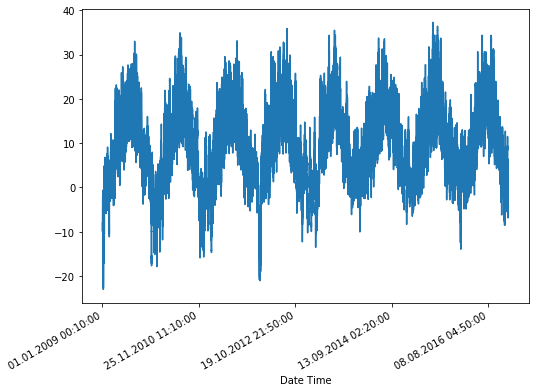

In [6]:
# Visualization the univariate
uni_data.plot(subplots=True)

#### DataPreprocessing
실제 Data를 Model에 넣을 Tensor로 변환하기 전에 Normalization과정을 실시하는 데이터 전처리 과정을 거친다.

In [7]:
uni_data = uni_data.values

# Z-Normalization
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

# Use Customizing Function
univariate_past_history = 20
univariate_future_target = 0

x_train_uni,y_train_uni = univariate_data(uni_data,0,TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)

x_val_uni,y_val_uni = univariate_data(uni_data,TRAIN_SPLIT,None,
                                     univariate_past_history,
                                     univariate_future_target)

# Check the Data
print('Single window of past history')
print(x_train_uni[0])
print('Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
Target temperature to predict
-2.1041848598100876


#### Visualization the Predict
실제 Model의 예측 결과를 Visualization하기 위하여 간단한 Function을 만든다.  
사용되는 각각의 Argument는 다음과 같다.  
- plot_data: Input+Label+Model Prediction
- delta: Time Range
- title: Tile of Plot

실제 Model은 아직 구성하지 않았으므로 평균값으로서 간단히 나타내면 다음과 같다.  

**참조**  
밑의 반복문을 살펴보면 처음보는 방식으로 되어있었다.  
Python에서는 0은 False, 나머지는 전부 True로 판단한다.

<module 'matplotlib.pyplot' from '/Users/jyhwang/opt/anaconda3/envs/Tensorflow2/lib/python3.7/site-packages/matplotlib/pyplot.py'>

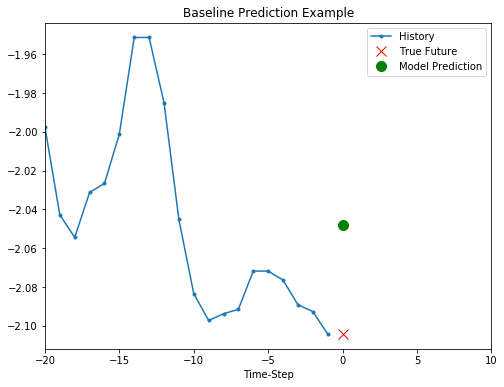

In [8]:
# Input Time Range
def create_time_steps(length):
    return list(range(-length, 0))

# Visualization the Predict
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

# Check the Visualization the Predict
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

#### Recurrent neural network
Keras를 사용하여 RNN의 Model중에서도 LSTM을 사용하여 Model을 구성하고 결과를 확인한다.  
어렵지 않은 부분이므로 아래 Code가 이해되지 않으면 링크를 참조하자.  
참조: <a href="https://wjddyd66.github.io/keras/Keras(4)/">Keras-텍스트와 시퀀스를 위한 딥러닝</a>

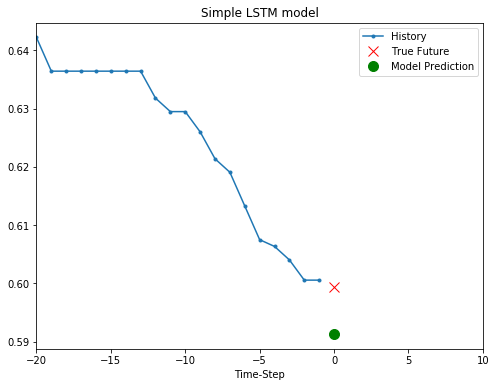

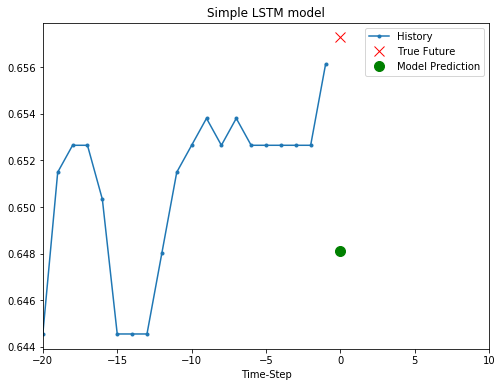

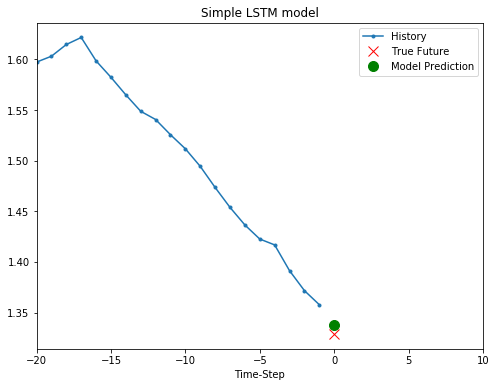

In [9]:
# Hyperparameter Setting
BATCH_SIZE = 256
BUFFER_SIZE = 10000

# Dataset -> Tensor
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

# Build Simple LSTM Model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

# Train the Model
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50,
                     verbose=0)

# Visualization the Model Predict
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

### Forecast a multivariate time series
위의 날씨 Data를 살펴보면 14개의 Columns가 존재한다. 위에서는 하나의 Columns를 가지고 예측하였지만 이번에는 여러개의 Columns를 가지고 결과를 예측하는 것을 확인한다.  
<br>

#### Check the dataset
사용하고자하는 Dataset의 여러가지 변수를 살펴보고 그 결과를 Visualziation하여 확인한다.

In [10]:
# Select the Columns
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

# Check the dataset
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x143d8a410>,
      dtype=object)

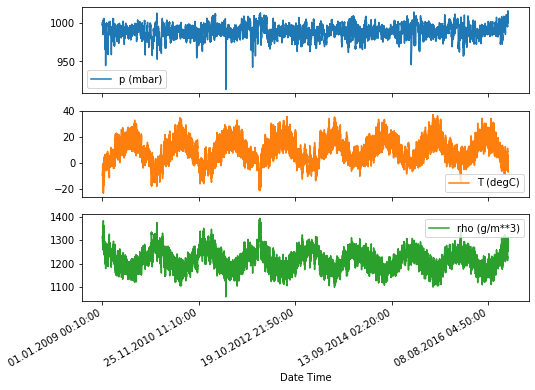

In [11]:
# Visualization the dataset
features.plot(subplots=True)

### Single Step Model
앞으로의 Single Step Model과 Multi Step Model에서 동시에 사용할 Function들을 정의한다.  
- Single Step Model: Model의 Prediction이 어느 특정 한 부분만을 예측한다.
- Multi Step Model: Model의 Prediction이 어느 특정 한 부분을 예측하는 것이 아닌 지정한 범위의 값을 예측한다.

#### Data Preprocessing
Univariate Model처럼 먼저 Model에 넣기 전에 데이터 전처리 과정을 실시한다.

In [12]:
# Z-Normalization
dataset = features.values
# axis = 0 Because of Multivariate
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

# Use Customizing Function for Single Step & Multi Step Model
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
            
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

#### Build the Single Step Model & Visualization Predict
실제 LSTM Model로서 다변량의 변수를 입력으로 넣고 Single Step을 Prediction하는 Model의 결과를 Visualization하여 확인한다.

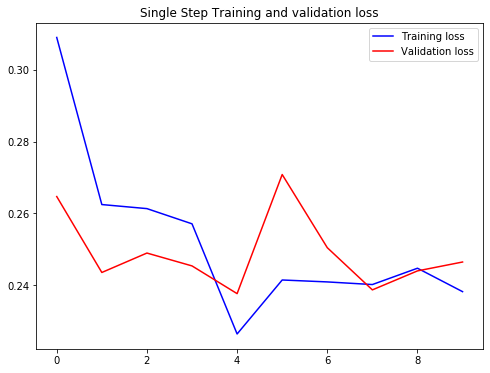

In [14]:
# Hyperparameter Setting
past_history = 720
future_target = 72
STEP = 6

# Use Customizing Function
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

# Dataset -> Tensor
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

# Build the Single Step Model
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.Dense(1)
])

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

# Train the Model
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50,
                                           verbose=0)

# Visualization the Model Loss
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

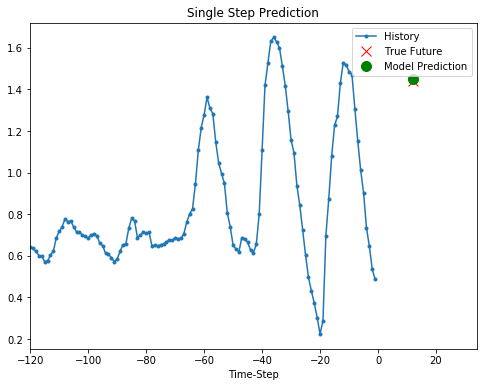

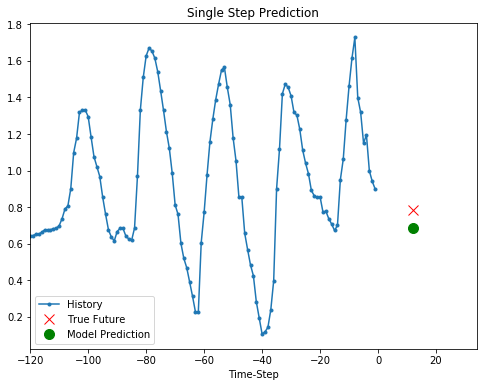

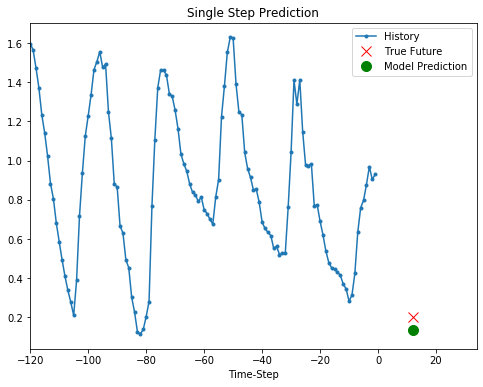

In [15]:
# Visualization the Model Prediction
# x - p(mbar), T(degC), rho(g/m**3)
# y - T(degC)
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

#### Multi-Step model
특정 한 Point가 아닌 주어진 구간동안에 결과값을 Prediction하여야 한다.  
해결 방법은 생각보다 간단하다.  
**기존 Single Step Model은 하나의 Point만 구하면 되었으므로 Model의 Output을 <code>tf.keras.layers(1)</code>로서 구현하였다. Multi-Step Model의 경우 원하는 구간만큼의 Output을 지정하면 된다.**

In [16]:
# Prepare Dataset that splited to train, label
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

# Dataset -> Tensor
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# Function that plot multi-step Model
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
# Build the Multi Step Model
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, 
                         return_sequences=True,
                         input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(16,activation='relu'),
    tf.keras.layers.Dense(72)
])

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#### Train & Visualization the Result

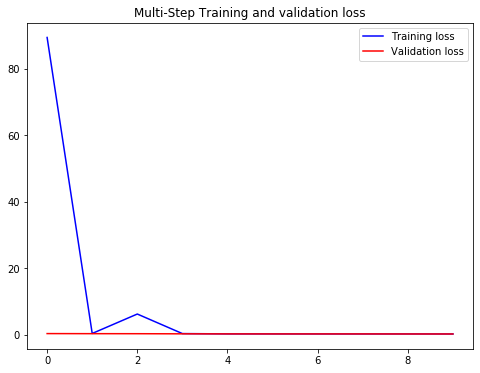

In [17]:
# Train the Model
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                         verbose=0)

# Visualization Loss
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Visualization the Model Prediction

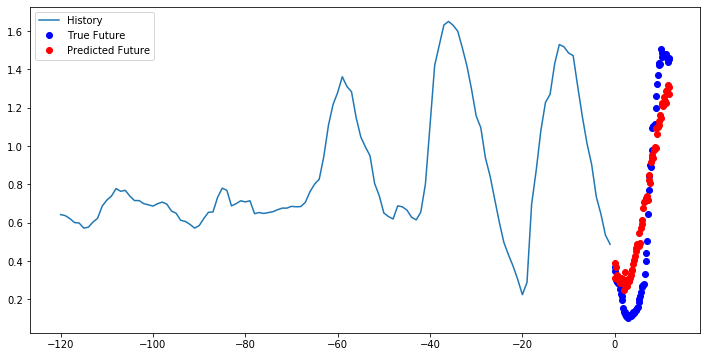

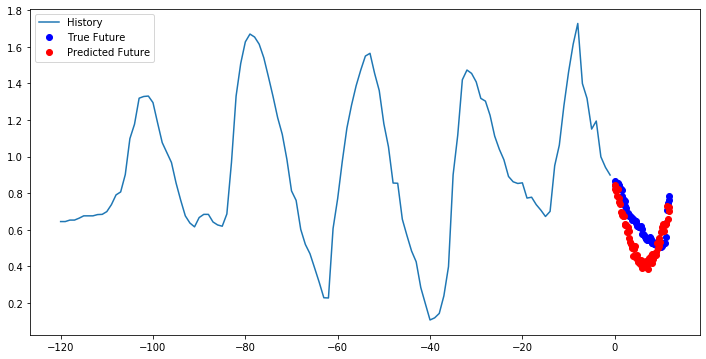

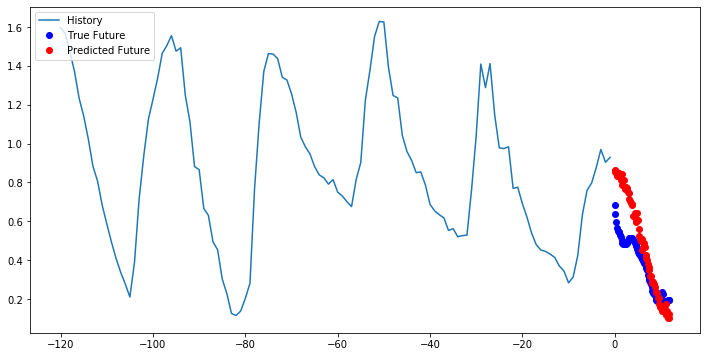

In [18]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])